In [50]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp
from pennylane.math import reduce_statevector


import time
import warnings
warnings.filterwarnings("ignore")

## Generating Bars and Stripes dataset

In [51]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 3
size = n**2
data = get_bars_and_stripes(n)



Sample bitstring: 100100100


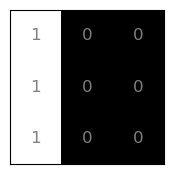

In [52]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

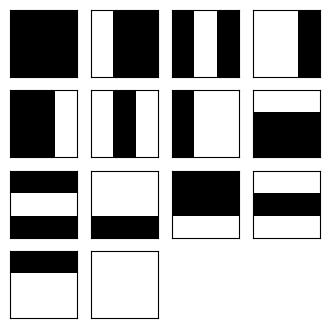

In [53]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [54]:
##append 7 0's to every element in data == 2**4
data = np.array([np.append(i, [0, 0, 0, 0, 0, 0, 0]) for i in data])

## Getting Wavefunction of Dataset

In [55]:
n_qubits = 4
n_ancillas = 4
total_qubits = n_qubits + n_ancillas

In [56]:
data = torch.tensor(data,dtype=torch.float32)

for d in data:
    eps = 1e-6
    if torch.linalg.norm(d) < 1e-8:
        d = torch.full_like(d,eps)

    d = d/torch.linalg.norm(d)

In [57]:
dm = torch.einsum("bi,bj -> bij",data,data)
target_dm = dm.mean(dim=0)
target_dm = target_dm / torch.linalg.norm(target_dm)

In [58]:
data[1]

tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [60]:
def encode_conditional_state_with_ancilla_last(data):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 16  # because 2^4 = 16 ancilla states
        psi_full[base_index + 0] = data[0][i]  # |000⟩ ancilla
        psi_full[base_index + 1] = data[1][i]  # |001⟩ ancilla
        psi_full[base_index + 2] = data[2][i]
        psi_full[base_index + 3] = data[3][i]
        psi_full[base_index + 4] = data[4][i]
        psi_full[base_index + 5] = data[5][i]
        psi_full[base_index + 6] = data[6][i]
        psi_full[base_index + 7] = data[7][i]
        psi_full[base_index + 8] = data[8][i]
        psi_full[base_index + 9] = data[9][i]
        psi_full[base_index + 10] = data[10][i]
        psi_full[base_index + 11] = data[11][i]
        psi_full[base_index + 12] = data[12][i]
        psi_full[base_index + 13] = data[13][i]

    return psi_full / torch.linalg.norm(psi_full)

data_full = encode_conditional_state_with_ancilla_last(data)
data_full.shape

torch.Size([256])

In [61]:
######## Verification of Encoding
# target_full_dm = torch.einsum("i,j -> ij",data_full,data_full)
# reduced_dm = reduce_statevector(data_full,range(n_qubits))
# reduced_dm /= torch.linalg.norm(reduced_dm)
target_full_dm = qml.math.dm_from_state_vector(data_full)
target_full_dm.shape

torch.Size([256, 256])

## Functions

In [12]:
def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance2_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance2 = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance2.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance2_loss(px, py)
    return loss


In [13]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)
        qml.RY(ising_params1[i],wires=i)
        qml.RZ(ising_params2[i],wires=i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[total_qubits-1,0])
    #     qml.IsingXY(ising_params1[i],wires=[i,i+1])
    # qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    # for i in range(total_qubits-1):
    #     qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    # qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds1 = 7

@qml.qnode(dev,interface="torch")
def circuit(input_params,folds=folds1,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    # for i in range(total_qubits):

        ## 1010.... initial state
        # if i%2 == 0:
        #     qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


In [14]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    px_dm = qml.math.dm_from_state_vector(px)

    return -1*qml.math.fidelity(px_dm,py) 

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    return fid_loss.real

## Training the Model

In [15]:
initial_params = torch.rand((folds1, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

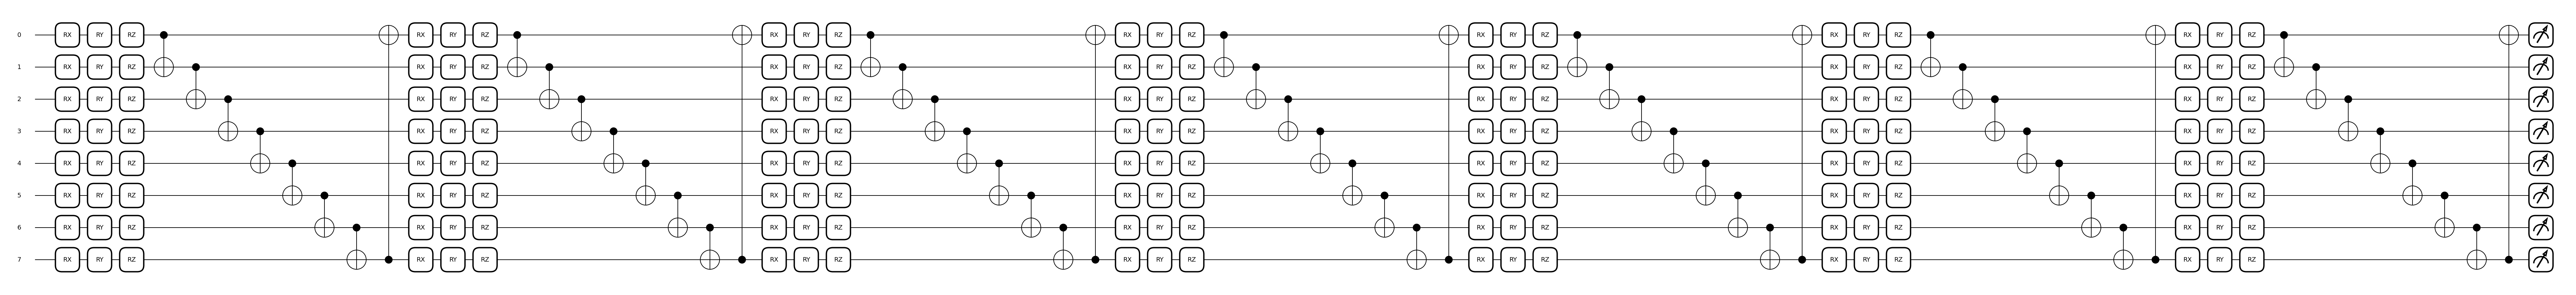

In [16]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [17]:
target_dm.shape

torch.Size([16, 16])

In [19]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds1, 3* total_qubits), dtype=torch.float32)
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.38445223317863086 Time taken per iter: 0.029287099838256836
Step: 20 Loss: 0.2832892461924682 Time taken per iter: 0.029221773147583008
Step: 30 Loss: 0.21931543738324483 Time taken per iter: 0.0345158576965332
Step: 40 Loss: 0.17188585231176365 Time taken per iter: 0.03204989433288574
Step: 50 Loss: 0.14303644059633844 Time taken per iter: 0.028879165649414062
Step: 60 Loss: 0.1270972262673783 Time taken per iter: 0.028918981552124023
Step: 70 Loss: 0.11608873379886046 Time taken per iter: 0.028076887130737305
Step: 80 Loss: 0.107282823799882 Time taken per iter: 0.028551816940307617
Step: 90 Loss: 0.09996765606296461 Time taken per iter: 0.028666973114013672
Step: 100 Loss: 0.09380375939202389 Time taken per iter: 0.028519153594970703
Step: 110 Loss: 0.08908451857371098 Time taken per iter: 0.0289461612701416
Step: 120 Loss: 0.08559778885703791 Time taken per iter: 0.03702116012573242
Step: 130 Loss: 0.08275548595763235 Time taken per iter: 0.03302717208862305
Step: 

Text(0.5, 1.0, 'Loss Over Epochs')

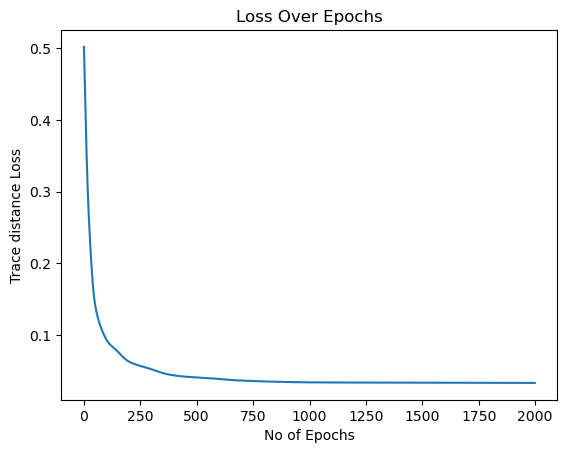

In [20]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [21]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.03302774848310946


In [22]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

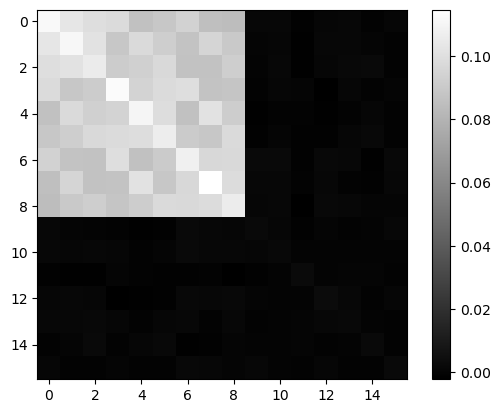

In [23]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

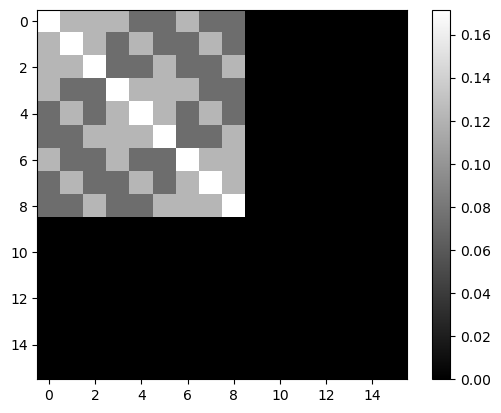

In [24]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

## Training over the Register Basis

In [25]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])
    #     qml.IsingXY(ising_params1[i],wires=[n_qubits+i,n_qubits+i+1])
    # qml.IsingXY(ising_params1[-1],wires=[n_qubits+total_qubits-1,n_qubits])


    # for i in range(total_qubits-1):
    #     qml.IsingZZ(ising_params2[i],wires=[n_qubits+i,n_qubits+i+1])
    # qml.IsingZZ(ising_params2[-1],wires=[n_qubits+total_qubits-1,n_qubits])


dev = qml.device("default.qubit",wires=total_qubits)
folds2 = 7

@qml.qnode(dev,interface="torch")
def reg_circuit(input_params,trained_params=optimal_params,folds=[folds1,folds2],num_qubits=n_ancillas,total_qubits=total_qubits):
    
    # for i in range(total_qubits):
    #     ## 1010.... initial state
    #     if i%2 == 0:
    #         qml.X(i)

    for i in range(folds[0]):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)

    for i in range(folds[1]):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)
    
    output = qml.state()

    return output


In [26]:
reg_params = torch.rand((folds2, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 12900x900 with 1 Axes>, <Axes: >)

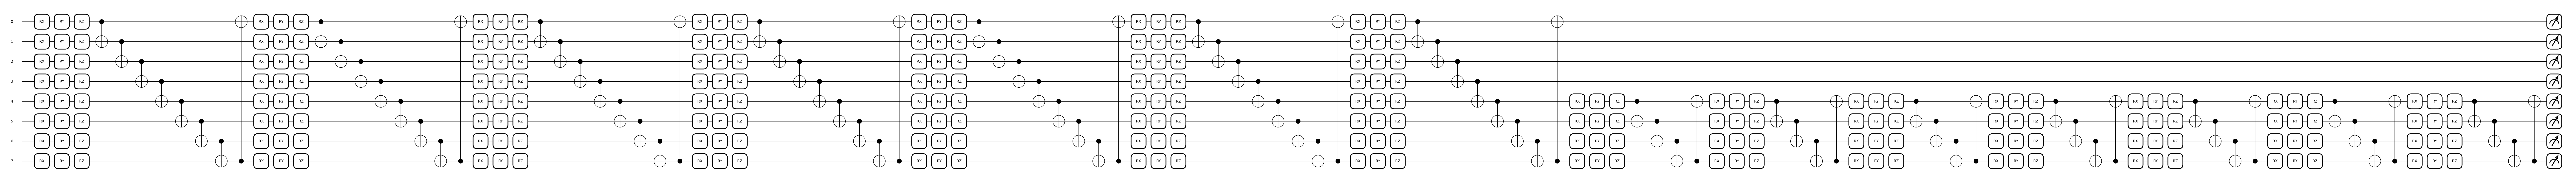

In [27]:
qml.draw_mpl(reg_circuit)(reg_params)

In [28]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.1)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds2, 3 * n_ancillas), dtype=torch.float32)
min_loss = vqc(reg_circuit, weights, target_full_dm)
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(loss_val.data)

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 10 Loss: -0.6351853945439238 Time taken per iter: 0.12026596069335938
Step: 20 Loss: -0.710712067882922 Time taken per iter: 0.1082451343536377
Step: 30 Loss: -0.7570123168591733 Time taken per iter: 0.09902596473693848
Step: 40 Loss: -0.7835751208458108 Time taken per iter: 0.09772324562072754
Step: 50 Loss: -0.8008001295720195 Time taken per iter: 0.09926986694335938
Step: 60 Loss: -0.8173084465901211 Time taken per iter: 0.11015129089355469
Step: 70 Loss: -0.8240673996072341 Time taken per iter: 0.09928774833679199
Step: 80 Loss: -0.8276265719878123 Time taken per iter: 0.09868001937866211
Step: 90 Loss: -0.8308756666811759 Time taken per iter: 0.10968494415283203
Step: 100 Loss: -0.8341341589772505 Time taken per iter: 0.09984159469604492
Step: 110 Loss: -0.8372257068441062 Time taken per iter: 0.1050112247467041
Step: 120 Loss: -0.840879123676825 Time taken per iter: 0.11304306983947754
Step: 130 Loss: -0.8471440176609065 Time taken per iter: 0.11054420471191406
Step: 140 Lo

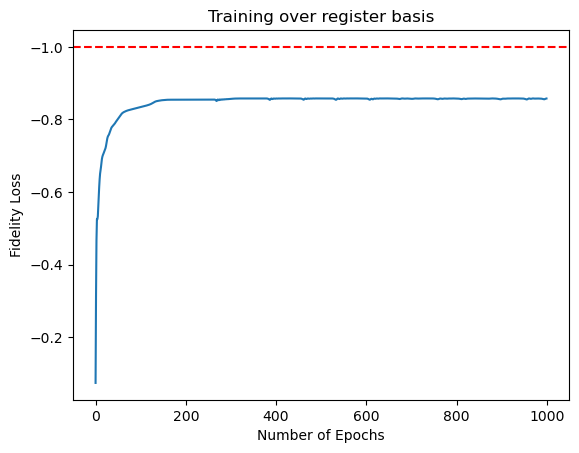

In [29]:
plt.plot(reg_loss_history)
plt.axhline(y=-1.0, color='r', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel("Number of Epochs")
plt.ylabel("Fidelity Loss")
plt.title("Training over register basis")
plt.show()

In [30]:
full_psi = reg_circuit(optimal_reg_params)

In [31]:
obtained_dm = reduce_statevector(full_psi, indices=range(n_qubits))
obtained_dm = obtained_dm / torch.linalg.norm(obtained_dm)

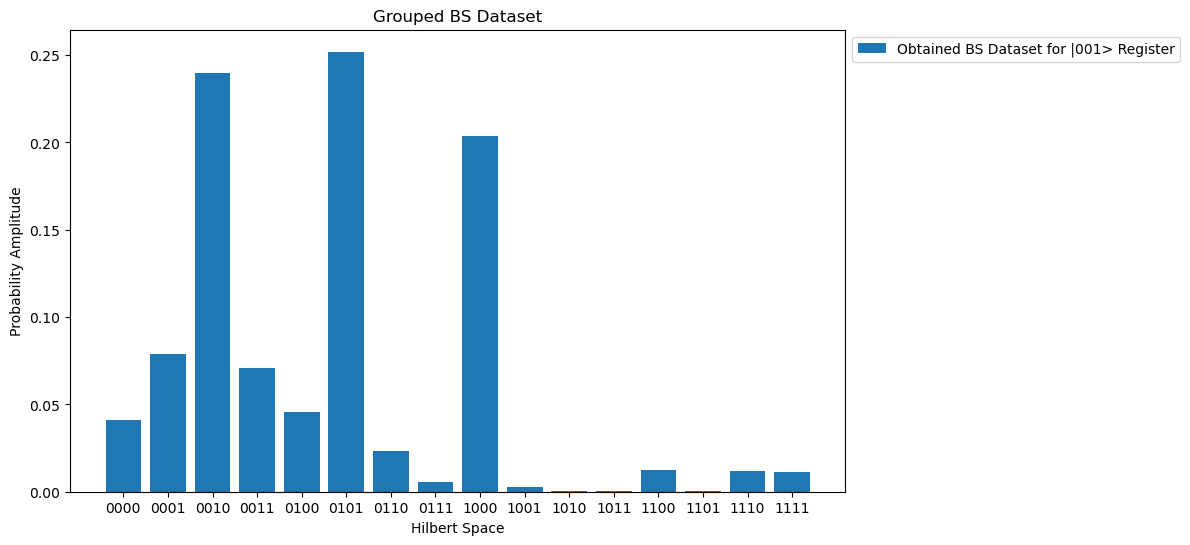

In [32]:
image = qnp.round(full_psi[4::16],3)
image /= qnp.linalg.norm(image)

x = ["0000", "0001", "0010", "0011", "0100", "0101", "0110", "0111", "1000", "1001", "1010", "1011", "1100", "1101", "1110", "1111"]

#make the xaxis label vertical
plt.figure(figsize=(10, 6))
plt.bar(x, np.abs(image)**2, label='Obtained BS Dataset for |001> Register')

plt.xlabel('Hilbert Space')
plt.ylabel('Probability Amplitude')
plt.title('Grouped BS Dataset')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [33]:
data[4]

tensor([0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

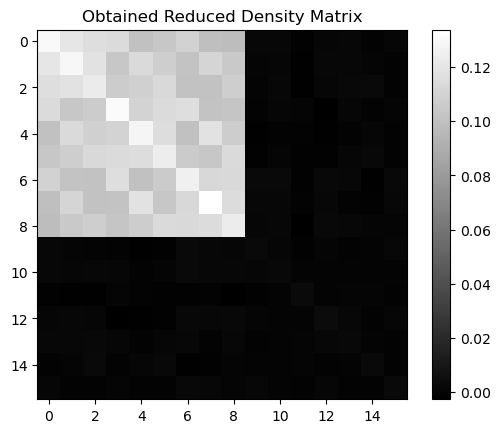

In [34]:
plt.imshow(obtained_dm.real, cmap="gray")
plt.colorbar()
plt.title("Obtained Reduced Density Matrix")
plt.show()

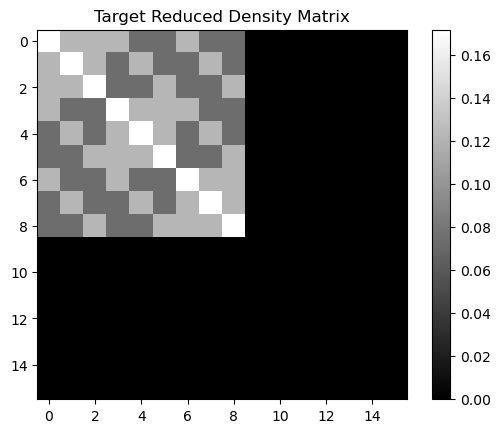

In [35]:
plt.imshow(target_dm.real, cmap="gray")
plt.colorbar()
plt.title("Target Reduced Density Matrix")
plt.show()

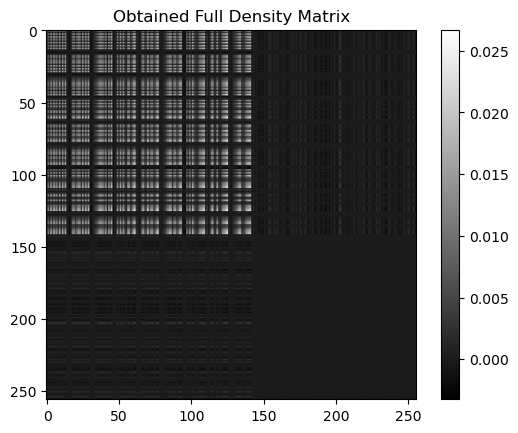

In [36]:
plt.imshow(qml.math.dm_from_state_vector(full_psi).real, cmap="grey")
plt.colorbar()
plt.title("Obtained Full Density Matrix")
plt.show()

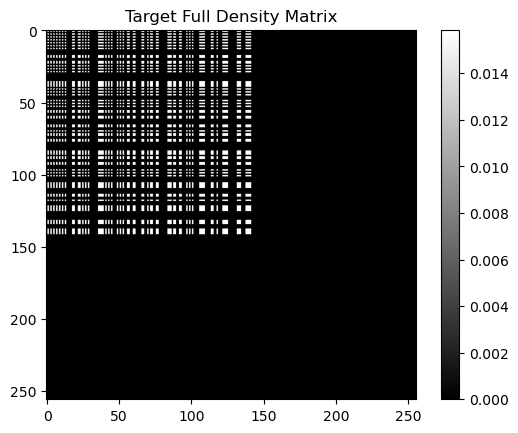

In [37]:
plt.imshow(target_full_dm.real, cmap="grey")
plt.colorbar()
plt.title("Target Full Density Matrix")
plt.show()